# Import Required Libraries
Import necessary libraries including OpenCV, NumPy, Matplotlib, and others needed for image processing and visualization.

In [1]:
# Import necessary libraries
import cv2  # OpenCV for image processing
import numpy as np  # NumPy for numerical operations
import matplotlib.pyplot as plt  # Matplotlib for visualization

# Ensure Matplotlib displays images inline in Jupyter Notebook
%matplotlib inline

# Load and Preprocess License Plate Image
Load the license plate image, resize if necessary, and convert to grayscale for processing.

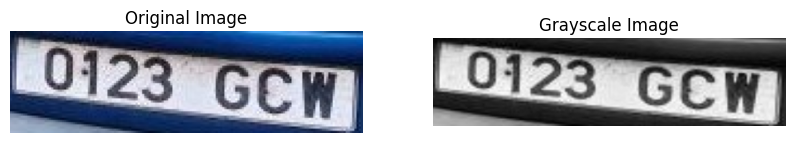

In [38]:
# Load and preprocess the license plate image

# Load the image using OpenCV (replace 'license_plate.jpg' with the path to your image)
image_path = '../matricula2.jpg'
license_plate_image = cv2.imread(image_path)

# Check if the image was loaded successfully
if license_plate_image is None:
    raise FileNotFoundError(f"Image not found at path: {image_path}")

# Resize the image if necessary (optional, adjust dimensions as needed)
resized_image = cv2.resize(license_plate_image, (400, 100))  # Example dimensions

# Convert the image to grayscale
grayscale_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

# Display the original and preprocessed images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(license_plate_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Grayscale Image")
plt.imshow(grayscale_image, cmap="gray")
plt.axis("off")

plt.show()

# Apply Thresholding and Binarization
Apply various thresholding techniques (Otsu, adaptive thresholding) to separate characters from the background.

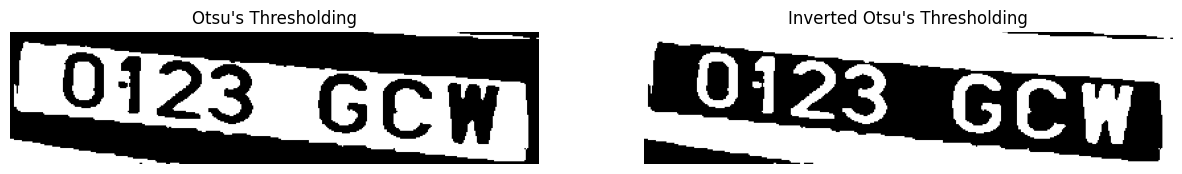

In [44]:
# Apply Thresholding and Binarization

# Apply Otsu's thresholding
thresh = cv2.threshold(grayscale_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
thresh_inv = cv2.bitwise_not(thresh)

# Display the thresholded images
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title("Otsu's Thresholding")
plt.imshow(thresh, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Inverted Otsu's Thresholding")
plt.imshow(thresh_inv, cmap="gray")
plt.axis("off")

plt.show()

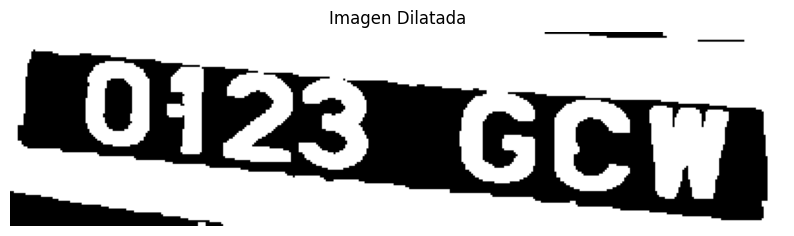

In [45]:
# Crear un kernel para la dilatación
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

# Aplicar dilatación para resaltar los caracteres
dilated_image = cv2.dilate(thresh_inv, kernel, iterations=1)

# Mostrar la imagen dilatada
plt.figure(figsize=(10, 5))
plt.title("Imagen Dilatada")
plt.imshow(dilated_image, cmap="gray")
plt.axis("off")
plt.show()

# Detect Contours in the Image
Use contour detection algorithms to find potential character boundaries in the binarized image.

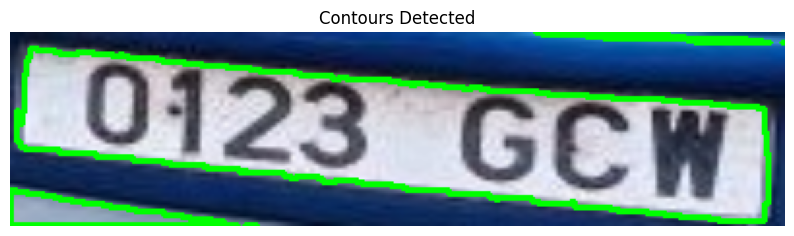

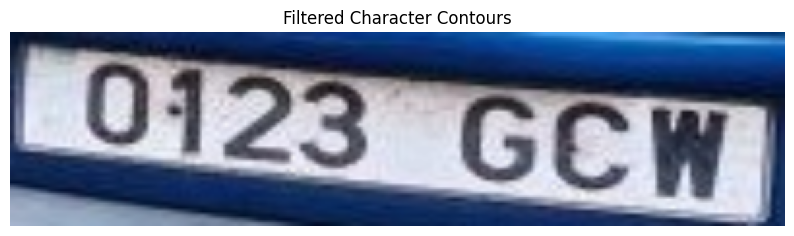

In [49]:
# Detect contours in the binarized image using Otsu's thresholding result
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a copy of the original resized image to draw contours
contour_image = resized_image.copy()

# Draw the detected contours on the image
cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)  # Green color for contours

# Display the image with contours
plt.figure(figsize=(10, 5))
plt.title("Contours Detected")
plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
plt.axis("off")
plt.show()

# Filter contours based on size to identify potential character regions
character_contours = []
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    aspect_ratio = w / float(h)
    if 0.2 < aspect_ratio < 1.0 and 15 < h < 100:  # Adjust thresholds as needed
        character_contours.append(contour)

# Draw filtered contours on the image
filtered_contour_image = resized_image.copy()
cv2.drawContours(filtered_contour_image, character_contours, -1, (255, 0, 0), 2)  # Blue color for filtered contours

# Display the filtered contours
plt.figure(figsize=(10, 5))
plt.title("Filtered Character Contours")
plt.imshow(cv2.cvtColor(filtered_contour_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
plt.axis("off")
plt.show()

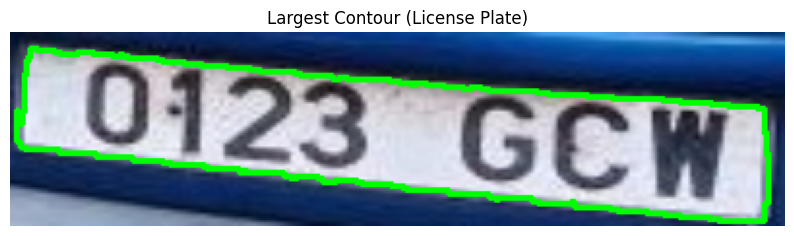

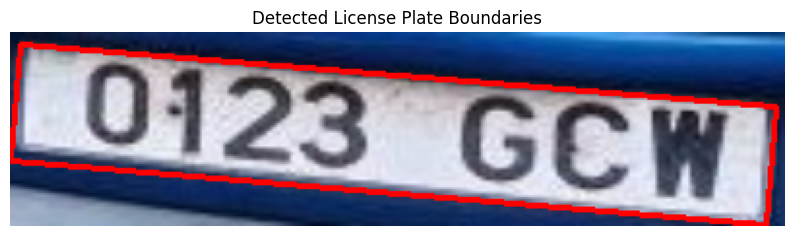

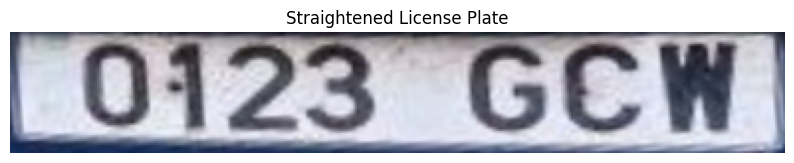

In [100]:
# Perspective Correction for License Plate

# First, find the license plate contour (usually among the largest contours)
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Sort contours by area (descending)
contours = sorted(contours, key=cv2.contourArea, reverse=True)

# Visualize the largest contour (usually the license plate)
largest_contour_img = resized_image.copy()
cv2.drawContours(largest_contour_img, [contours[0]], -1, (0, 255, 0), 2)
plt.figure(figsize=(10, 5))
plt.title("Largest Contour (License Plate)")
plt.imshow(cv2.cvtColor(largest_contour_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

# Get the minimum area rectangle that contains the license plate
rect = cv2.minAreaRect(contours[0])
box = cv2.boxPoints(rect)
box = np.int32(box)

# Draw the rotated rectangle
rotated_rect_img = resized_image.copy()
cv2.drawContours(rotated_rect_img, [box], 0, (0, 0, 255), 2)
plt.figure(figsize=(10, 5))
plt.title("Detected License Plate Boundaries")
plt.imshow(cv2.cvtColor(rotated_rect_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

# Function to order points in [top-left, top-right, bottom-right, bottom-left]
def order_points(pts):
    # Sort by X coordinates
    xSorted = pts[np.argsort(pts[:, 0]), :]
    
    # Grab the left-most and right-most points
    leftMost = xSorted[:2, :]
    rightMost = xSorted[2:, :]
    
    # Sort left-most points by Y coordinates
    leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
    (tl, bl) = leftMost
    
    # Sort right-most points by Y coordinates
    rightMost = rightMost[np.argsort(rightMost[:, 1]), :]
    (tr, br) = rightMost
    
    return np.array([tl, tr, br, bl], dtype="float32")

# Order the points in the correct sequence
ordered_box = order_points(box)

# Get width and height of the new image
width = int(np.max([
    np.linalg.norm(ordered_box[0] - ordered_box[1]),
    np.linalg.norm(ordered_box[2] - ordered_box[3])
]))

height = int(np.max([
    np.linalg.norm(ordered_box[0] - ordered_box[3]),
    np.linalg.norm(ordered_box[1] - ordered_box[2])
]))

# Define the destination points for the perspective transform
dst = np.array([
    [0, 0],
    [width - 1, 0],
    [width - 1, height - 1],
    [0, height - 1]
], dtype="float32")

# Compute the perspective transform matrix
M = cv2.getPerspectiveTransform(ordered_box, dst)

# Apply the perspective transformation
warped = cv2.warpPerspective(resized_image, M, (width, height))

# Display the warped (straightened) license plate
plt.figure(figsize=(10, 5))
plt.title("Straightened License Plate")
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

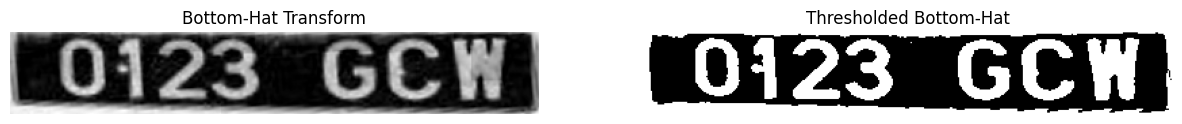

In [128]:
# Convert the warped image to grayscale for further processing
warped_gray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)

# Apply Bottom-Hat morphological operation to extract dark text on light background

# Create a kernel for the Bottom-Hat operation
# Using a slightly larger kernel to capture character features
bottomhat_kernel = np.ones((24, 24), np.uint8)

# Apply Bottom-Hat transformation (closing - original image)
# This helps extract dark text from light background
bottomhat = cv2.morphologyEx(warped_gray, cv2.MORPH_BLACKHAT, bottomhat_kernel)

# Apply contrast enhancement to the Bottom-Hat result
clahe_bottomhat = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
bottomhat_enhanced = clahe_bottomhat.apply(bottomhat)

# Apply thresholding to the enhanced image to binarize it
_, bottomhat_thresh = cv2.threshold(bottomhat_enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Display the results
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title("Bottom-Hat Transform")
plt.imshow(bottomhat, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Thresholded Bottom-Hat")
plt.imshow(bottomhat_thresh, cmap="gray")
plt.axis("off")

plt.show()

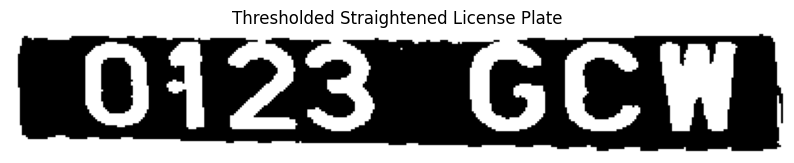

In [121]:
# Apply Otsu's thresholding to the straightened license plate
_, warped_thresh = cv2.threshold(warped_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Display the thresholded straightened license plate
plt.figure(figsize=(10, 5))
plt.title("Thresholded Straightened License Plate")
plt.imshow(warped_thresh, cmap="gray")
plt.axis("off")
plt.show()

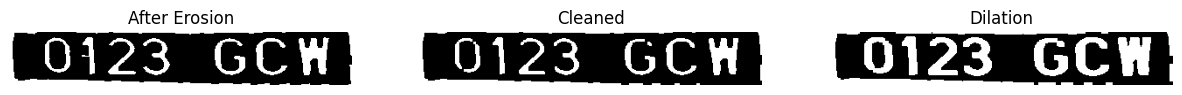

In [133]:
# Apply erosion to remove small noise points from the thresholded image

# Create a slightly larger kernel for erosion
erosion_kernel = np.ones((4, 4), np.uint8)

# Apply erosion to the warped threshold image
eroded_image = cv2.erode(bottomhat_thresh, erosion_kernel, iterations=1)

# Apply additional preprocessing to clean the image
# Use opening morphology to remove small noise
opening_kernel = np.ones((3, 3), np.uint8)
cleaned_image = cv2.morphologyEx(eroded_image, cv2.MORPH_OPEN, opening_kernel)

# Apply dilation to reconnect potentially broken character parts
dilation_kernel = np.ones((3, 5), np.uint8)
dilated = cv2.dilate(cleaned_image, dilation_kernel, iterations=1)

# Display the original thresholded image and the cleaned image
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("After Erosion")
plt.imshow(eroded_image, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Cleaned")
plt.imshow(cleaned_image, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Dilation")
plt.imshow(dilated, cmap="gray")
plt.axis("off")

plt.show()

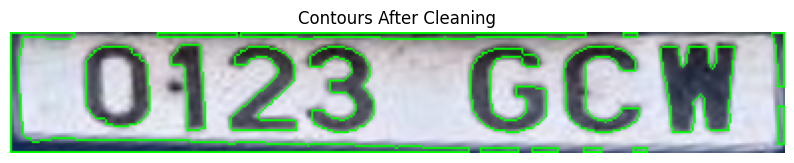

In [134]:
# Find contours in the cleaned image
contours_cleaned, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw all contours on a copy of the warped image
contour_image = warped.copy()
cv2.drawContours(contour_image, contours_cleaned, -1, (0, 255, 0), 1)

plt.figure(figsize=(10, 5))
plt.title("Contours After Cleaning")
plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

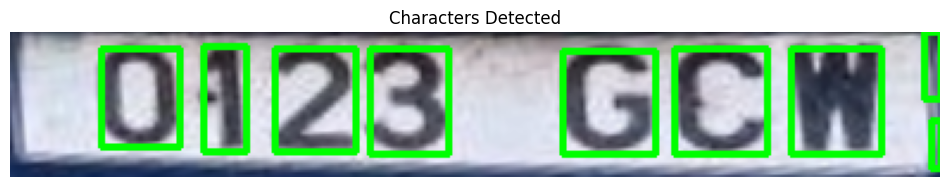

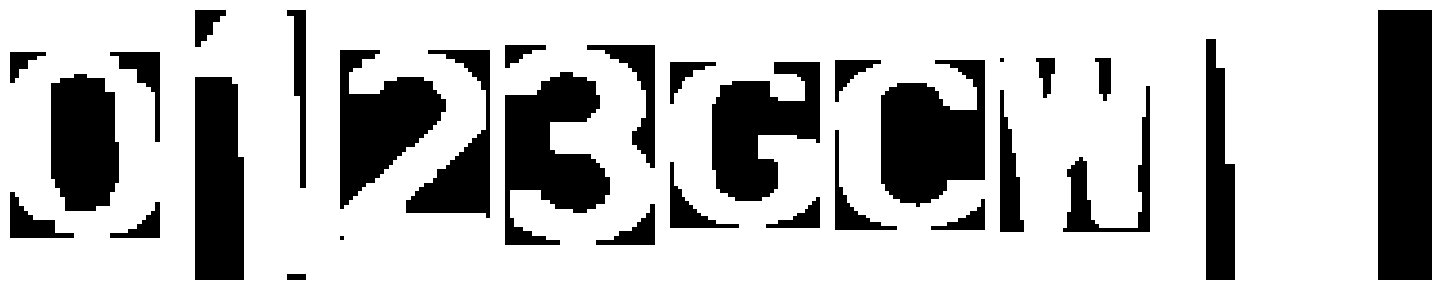

In [135]:
# Segment characters from the license plate

# Sort contours from left to right to get characters in reading order
contours_cleaned_list = list(contours_cleaned)
sorted_contours = sorted(contours_cleaned_list, key=lambda c: cv2.boundingRect(c)[0])

# Create a copy of the warped image to draw bounding boxes on
character_image = warped.copy()

# List to store individual character images
character_images = []

# Process each contour
for i, contour in enumerate(sorted_contours):
    # Get the bounding rectangle for the contour
    x, y, w, h = cv2.boundingRect(contour)
    
    # Filter contours based on aspect ratio and size (characters in license plates)
    aspect_ratio = w / float(h)
    area = cv2.contourArea(contour)
    
    # Adjust these thresholds based on your specific license plate
    if 0.1 < aspect_ratio < 1.5 and area > 30 and h > 10:
        # Draw a rectangle around the character
        cv2.rectangle(character_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
        # Extract the character from the binary image
        char_roi = dilated[y:y+h, x:x+w]
        
        # Add to our list of character images
        character_images.append((x, char_roi))

# Sort characters by x-coordinate to get them in the correct order
character_images.sort(key=lambda x: x[0])

# Display the characters with bounding boxes
plt.figure(figsize=(12, 5))
plt.title("Characters Detected")
plt.imshow(cv2.cvtColor(character_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

# Display each extracted character
plt.figure(figsize=(15, 3))
for i, (_, char_img) in enumerate(character_images):
    if i < 15:  # Limit to avoid too many subplots
        plt.subplot(1, min(len(character_images), 15), i+1)
        plt.imshow(char_img, cmap='gray')
        plt.axis('off')
plt.tight_layout()
plt.show()